In [1]:
!pip -q install --upgrade pip
!pip -q install numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 matplotlib==3.9.2 seaborn==0.13.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
df = pd.read_csv("/content/Monkeypox_Dataset.csv")
print(df.shape)
df.head()


(25000, 18)


,Test ID,Systemic Illness,Encoded Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Red blood cells count,White blood cells count,Home ownership,Age,Month of Birth,Health Insurance,Sexually Transmitted Infection,MPOX PCR Result
0,AA0021,NaN,0.0,0.0,1,1.0,1,0,1.0,0.0,5363690,9382,1,37,10,0,0.0,Negative
1,AA0022,Fever,1.0,1.0,0,1.0,1,0,0.0,1.0,5797376,7891,0,24,7,1,0.0,Positive
2,AA0023,Fever,1.0,0.0,1,1.0,0,0,0.0,1.0,4509503,9424,0,34,11,1,0.0,Positive
3,AA0024,NaN,0.0,1.0,0,0.0,0,1,1.0,1.0,4613306,4608,1,40,3,0,0.0,Positive
4,AA0025,Swollen Lymph Nodes,3.0,1.0,1,1.0,0,0,1.0,1.0,5423126,10668,1,36,8,0,0.0,Positive


In [3]:
# --- Fix schema issues ---
# 1. Convert Age to numeric
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# 2. Drop identifier columns
if "Test ID" in df.columns:
    df = df.drop(columns=["Test ID"])

print("Columns after cleaning:", df.columns.tolist())


Columns after cleaning: ['Systemic Illness', 'Encoded Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Red blood cells count', 'White blood cells count', 'Home ownership', 'Age', 'Month of Birth', 'Health Insurance', 'Sexually Transmitted Infection', 'MPOX PCR Result']


In [4]:
import numpy as np

# 1) Set your target column name here
TARGET = "MPOX PCR Result"

# 2) Quick label normalization (handles text labels like yes/no/true/false)
if df[TARGET].dtype == object:
    df[TARGET] = (
        df[TARGET]
        .astype(str).str.strip().str.upper()
        .replace({"YES":1, "NO":0, "TRUE":1, "FALSE":0})
    )

# 3) Split features and target; auto-detect numeric vs categorical
X = df.drop(columns=[TARGET])
y = df[TARGET]

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

print("Numeric:", len(num_cols), "Categorical:", len(cat_cols))
print("Target classes:", sorted(pd.Series(y).dropna().unique()))


Numeric: 14 Categorical: 2
Target classes: ['NEGATIVE', 'POSITIVE']


Missing values (top 20):


,0
Systemic Illness,6216
Age,37
Swollen Tonsils,7
Penile Oedema,6
HIV Infection,5
Sexually Transmitted Infection,4
Oral Lesions,4
Rectal Pain,3
Encoded Systemic Illness,2
Solitary Lesion,0



Class balance:


,proportion
MPOX PCR Result,
POSITIVE,0.63636
NEGATIVE,0.36364


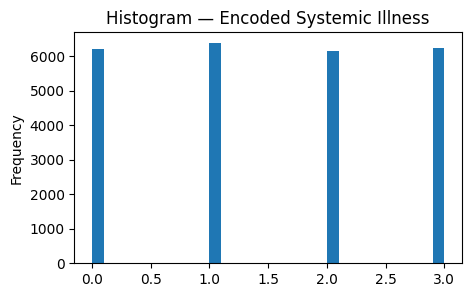

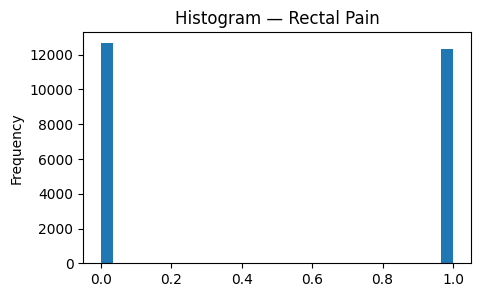

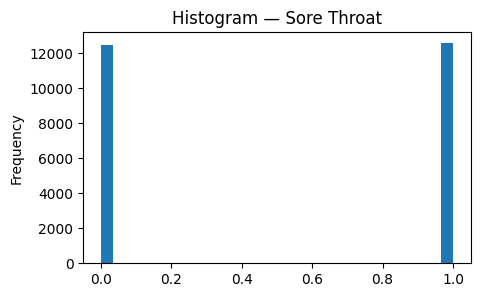

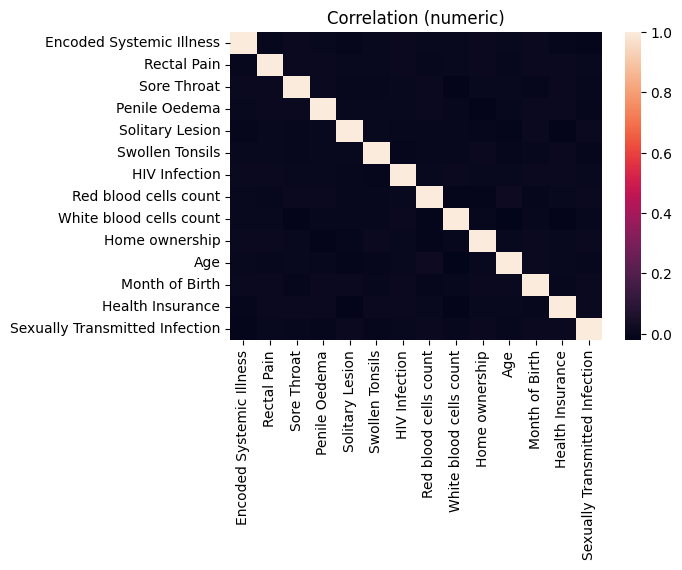

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Missing values (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

print("\nClass balance:")
display(pd.Series(y).value_counts(normalize=True).rename("proportion"))

# Plot 3 quick histograms for numerics (if any)
for col in num_cols[:3]:
    ax = df[col].plot(kind="hist", bins=30, figsize=(5,3), title=f"Histogram — {col}")
    plt.show()

# Simple correlation (only numeric features + target if numeric)
if len(num_cols) > 1:
    corr_cols = [c for c in num_cols if c in df.columns]
    if pd.api.types.is_numeric_dtype(df[TARGET]):
        corr_cols = [TARGET] + corr_cols
    corr = df[corr_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=False)
    plt.title("Correlation (numeric)")
    plt.show()


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Encoded Systemic Illness', 'Rectal Pain',
                                  'Sore Throat', 'Penile Oedema',
                                  'Solitary Lesion', 'Swollen Tonsils',
                                  'HIV Infection', 'Red blood cells count',
                                  'White blood cells count', 'Home ownership',
                                  'Age', 'Month of Birth', 'Health Insurance',
                                  'Sexually Transmitted Infection']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Oral Lesions', 'Systemic Illness'])])

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y if y.nunique() <= 20 else None
)

model = LogisticRegression(max_iter=500, class_weight="balanced")
pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
pipe.fit(X_train, y_train)
print("Trained.")


Trained.


{'accuracy': 0.643, 'f1': 0.698, 'roc_auc': np.float64(0.704)}


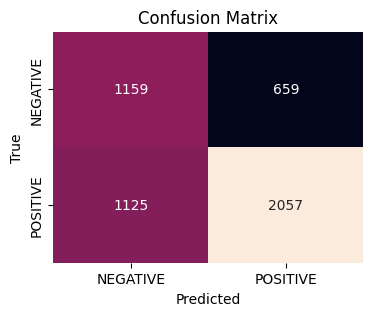

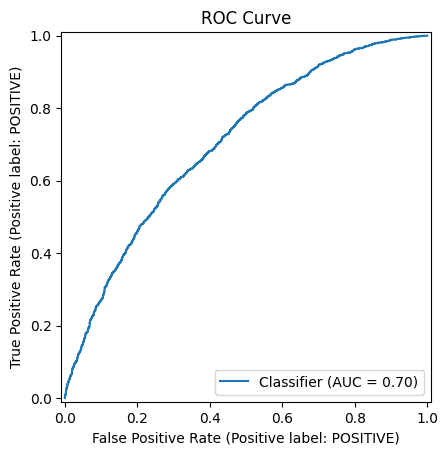

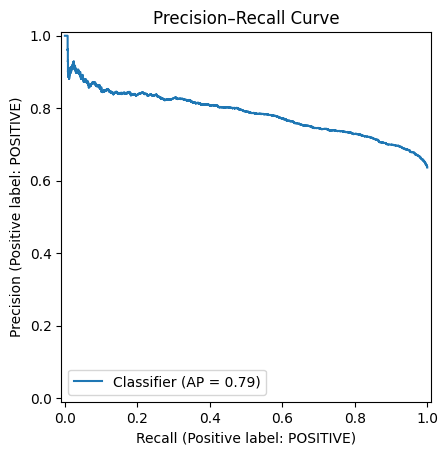

In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Try to get probabilities (binary classification)
try:
    y_prob = pipe.predict_proba(X_test)[:,1]
except Exception:
    y_prob = None

# Default threshold = 0.5 if probs exist
if (y_prob is not None) and (y.nunique()==2):
    y_pred = (y_prob >= 0.5).astype(int)
    # Convert predicted labels to strings to match y_test
    y_pred = np.where(y_pred == 1, 'POSITIVE', 'NEGATIVE')
else:
    y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="binary" if y.nunique()==2 else "macro", pos_label='POSITIVE')
auc = roc_auc_score(y_test, y_prob) if (y_prob is not None and y.nunique()==2) else None

print({"accuracy": round(acc,3), "f1": round(f1,3), "roc_auc": (round(auc,3) if auc is not None else None)})

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['NEGATIVE', 'POSITIVE'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=['NEGATIVE', 'POSITIVE'], yticklabels=['NEGATIVE', 'POSITIVE'])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# Curves (binary only & prob available)
if y_prob is not None and y.nunique()==2:
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax, pos_label='POSITIVE'); plt.title("ROC Curve"); plt.show()

    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax, pos_label='POSITIVE'); plt.title("Precision–Recall Curve"); plt.show()

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

scoring = "roc_auc" if y.nunique()==2 else "f1_macro"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) if y.nunique()<=20 else 5
scores = cross_val_score(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1)
print(f"{scoring} (CV 5-fold): mean={scores.mean():.3f}, std={scores.std():.3f}")


roc_auc (CV 5-fold): mean=0.700, std=0.002


In [10]:
import joblib
MODEL_PATH = "mpox_pipeline.joblib"
joblib.dump(pipe, MODEL_PATH)
MODEL_PATH


'mpox_pipeline.joblib'

In [15]:
%%writefile app.py
import pandas as pd
import numpy as np
import streamlit as st
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)

st.set_page_config(page_title="Mpox Predictor — Evaluator & Deployer", layout="wide")
st.title("Monkeypox (Mpox) — Predictor & Evaluator")

# =========================
# Config
# =========================
DEFAULT_TARGET_CANDIDATES = [
    "MPOX PCR Result", "mpox_result", "result", "label", "target",
    "status", "diagnosis", "outcome"
]
LABEL_MAP = {"NEGATIVE": 0, "POSITIVE": 1, "NO": 0, "YES": 1, "FALSE": 0, "TRUE": 1}

# =========================
# Load trained pipeline
# =========================
@st.cache_resource
def load_model(path="mpox_pipeline.joblib"):
    return joblib.load(path)

pipe = load_model()  # expects a pipeline with a ColumnTransformer named "preprocess"

# =========================
# Helpers
# =========================
def normalize_labels(series: pd.Series) -> pd.Series:
    """Map common string labels to 0/1; fall back to factorize if needed."""
    s = pd.Series(series)
    if s.dtype == object:
        mapped = s.astype(str).str.strip().str.upper().map(LABEL_MAP)
        if mapped.isna().any():
            codes, uniques = pd.factorize(s, sort=True)
            st.info(f"Factorized target to integers: {dict(enumerate(uniques.astype(str)))}")
            return pd.Series(codes, index=s.index).astype(int)
        return mapped.astype(int)
    return s.astype(int)

def get_expected_features_from_pipeline(pipe):
    """
    Returns (numeric_cols, categorical_cols) expected by the preprocessor
    BEFORE scaling/encoding.
    """
    pre = None
    try:
        pre = pipe.named_steps.get("preprocess") or pipe.named_steps.get("preprocessor")
    except Exception:
        pass

    num_cols, cat_cols = [], []
    if pre and hasattr(pre, "transformers_"):
        for name, trans, cols in pre.transformers_:
            if name == "num":
                num_cols = list(cols)
            elif name == "cat":
                cat_cols = list(cols)
    return num_cols, cat_cols

def get_transformed_feature_names(pipe):
    """
    Return feature names AFTER preprocessing (numeric + one-hot categorical),
    aligned to model coefficients/importances.
    """
    pre = pipe.named_steps.get("preprocess") or pipe.named_steps.get("preprocessor")
    if pre is None:
        return None
    exp_num, exp_cat = get_expected_features_from_pipeline(pipe)

    # OneHotEncoder is typically at pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = []
    try:
        ohe = pre.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(exp_cat).tolist() if len(exp_cat) else []
    except Exception:
        cat_names = []
    return list(exp_num) + list(cat_names)

def validate_feature_columns(df_features, expected_num, expected_cat):
    """
    Compare uploaded features vs expected features and return (missing, extra).
    """
    expected = set(expected_num) | set(expected_cat)
    present = set(df_features.columns)
    missing = sorted([c for c in expected if c not in present])
    extra   = sorted([c for c in present if c not in expected])
    return missing, extra

def unwrap_estimator(m):
    """If model is wrapped (e.g., CalibratedClassifierCV), return underlying estimator if present."""
    for attr in ("estimator", "base_estimator"):
        if hasattr(m, attr) and getattr(m, attr) is not None:
            return getattr(m, attr)
    return m

def render_confusion_matrix(y_true, y_pred, labels=(0,1), names=("NEGATIVE", "POSITIVE")):
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=[names[l] for l in labels],
                yticklabels=[names[l] for l in labels],
                ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    st.pyplot(fig)

# --- Coerce numeric columns (handles words like "twenty", "yes"/"no") ---
def coerce_numeric_columns(df: pd.DataFrame, numeric_cols: list[str]) -> tuple[pd.DataFrame, dict]:
    """
    Returns (df_out, report). df_out has numeric_cols coerced to numbers.
    Any non-numeric tokens become NaN (imputer will handle). 'yes'/'no' → 1/0.
    Report: {col: {"coerced": int, "nans_after": int}}
    """
    base = {
        "zero":0,"one":1,"two":2,"three":3,"four":4,"five":5,"six":6,"seven":7,"eight":8,"nine":9,"ten":10,
        "eleven":11,"twelve":12,"thirteen":13,"fourteen":14,"fifteen":15,"sixteen":16,"seventeen":17,"eighteen":18,"nineteen":19,
        "twenty":20,"thirty":30,"forty":40,"fifty":50,"sixty":60,"seventy":70,"eighty":80,"ninety":90,
        "yes":1,"no":0,"true":1,"false":0
    }
    def words_to_num(s: str) -> str:
        if not isinstance(s, str):
            return s
        t = s.lower().strip().replace("-", " ")
        if t in base:
            return str(base[t])
        parts = [p for p in t.split() if p]
        if len(parts)==2 and parts[0] in base and parts[1] in base and base[parts[0]]%10==0:
            return str(base[parts[0]] + base[parts[1]])
        return s  # leave as-is

    out = df.copy()
    report = {}
    for col in numeric_cols:
        if col not in out.columns:
            continue
        s = out[col]
        s2 = s.astype(str)
        s2 = s2.where(~s2.str.fullmatch(r"\s*nan\s*", case=False, na=False), other=np.nan)
        s2 = s2.fillna("")
        s2 = s2.apply(lambda x: words_to_num(x) if isinstance(x, str) else x)
        coerced = pd.to_numeric(s2.replace({"": np.nan}), errors="coerce")
        out[col] = coerced
        report[col] = {
            "coerced": int((~pd.to_numeric(s, errors="coerce").notna()).sum()),
            "nans_after": int(coerced.isna().sum())
        }
    return out, report

# =========================
# Feature Info (dynamic)
# =========================
with st.expander("ℹ️ Feature Info"):
    st.write("**Model expects the following feature columns (preprocessing input):**")
    try:
        exp_num, exp_cat = get_expected_features_from_pipeline(pipe)
        if exp_num:
            st.markdown(f"- **Numeric** ({len(exp_num)}): {', '.join(exp_num)}")
        if exp_cat:
            st.markdown(f"- **Categorical** ({len(exp_cat)}): {', '.join(exp_cat)}")
        if not exp_num and not exp_cat:
            st.info("Could not extract schema from pipeline. Showing generic guidance instead.")
            st.markdown("- **Numeric**: e.g., Age, blood counts\n- **Categorical**: e.g., Systemic Illness, STI, HIV Infection")
    except Exception as e:
        st.warning(f"Schema not available: {e}")
        st.markdown("- **Numeric**: e.g., Age, blood counts\n- **Categorical**: e.g., Systemic Illness, STI, HIV Infection")

    st.markdown("""
    **Target column (optional):**
    - Use `MPOX PCR Result` (Positive / Negative) for evaluation.
    - For pure predictions on new data, skip the target column.
    """)

# =========================
# File upload
# =========================
uploaded = st.file_uploader("Upload CSV for evaluation/prediction", type=["csv"])

if not uploaded:
    st.info("Upload a CSV to start. For evaluation, include the target column (e.g., `MPOX PCR Result`).")
    st.stop()

df = pd.read_csv(uploaded)
st.subheader("Preview")
st.dataframe(df.head())

# =========================
# Tabs
# =========================
tab_eval, tab_pred = st.tabs(["📊 Evaluate (if target present)", "🔮 Predict"])

# =========================
# Evaluate tab
# =========================
with tab_eval:
    st.write("If your CSV includes a target column (e.g., `MPOX PCR Result`), choose it below to compute metrics and plots.")
    default_idx = 0
    if "MPOX PCR Result" in df.columns:
        default_idx = 1 + list(df.columns).index("MPOX PCR Result")
    target_choice = st.selectbox("Target column (pick if present)", ["(none)"] + list(df.columns), index=default_idx)
    thresh = st.slider("Decision threshold (prob ≥ threshold → Positive)", 0.05, 0.95, 0.50, 0.01)

    if target_choice != "(none)":
        TARGET = target_choice

        if TARGET not in df.columns:
            st.error(f"Target '{TARGET}' not found.")
            st.stop()

        # Split features/labels
        X = df.drop(columns=[TARGET])
        y_raw = df[TARGET]
        y = normalize_labels(y_raw)

        # Coerce expected numeric columns first
        exp_num, exp_cat = get_expected_features_from_pipeline(pipe)
        X, coerce_report = coerce_numeric_columns(X, exp_num)
        bad_cols = [c for c, r in coerce_report.items() if r["coerced"] > 0]
        if bad_cols:
            st.warning("Coerced non-numeric values to numbers in: " + ", ".join(bad_cols) +
                       ". Any unrecognized tokens became NaN (imputed downstream).")

        # Schema validation
        missing, extra = validate_feature_columns(X, exp_num, exp_cat)
        if missing:
            st.error("Your file is missing required features:\n- " + "\n- ".join(missing))
            st.stop()
        if extra:
            st.info("These columns are not used by the model and will be ignored:\n- " + "\n- ".join(extra))

        # Predict probabilities if available
        y_prob = None
        try:
            y_prob = pipe.predict_proba(X)[:, 1]
        except Exception:
            pass

        # Predictions with threshold if probs available
        if y_prob is not None and y.nunique() == 2:
            y_pred = (y_prob >= thresh).astype(int)
        else:
            y_pred = pipe.predict(X)
            y_pred = pd.Series(y_pred).astype(int).values

        # Metrics
        acc = accuracy_score(y, y_pred)
        f1  = f1_score(y, y_pred, average="binary" if y.nunique()==2 else "macro")
        auc = roc_auc_score(y, y_prob) if (y_prob is not None and y.nunique()==2) else None

        c1, c2, c3 = st.columns(3)
        c1.metric("Accuracy", f"{acc:.3f}")
        c2.metric("F1", f"{f1:.3f}")
        c3.metric("ROC AUC", f"{auc:.3f}" if auc is not None else "—")

        # Confusion Matrix
        st.write("#### Confusion Matrix")
        render_confusion_matrix(y, y_pred, labels=(0,1), names=("NEGATIVE","POSITIVE"))

        # Curves
        if y_prob is not None and y.nunique()==2:
            st.write("#### ROC Curve")
            fig, ax = plt.subplots()
            RocCurveDisplay.from_predictions(y, y_prob, ax=ax)
            st.pyplot(fig)

            st.write("#### Precision–Recall Curve")
            fig, ax = plt.subplots()
            PrecisionRecallDisplay.from_predictions(y, y_prob, ax=ax)
            st.pyplot(fig)

            # Suggest an F1-optimal threshold
            precisions, recalls, thrs = precision_recall_curve(y, y_prob)
            f1s = 2 * (precisions * recalls) / np.clip(precisions + recalls, 1e-9, None)
            if len(thrs) > 0:
                best_idx = int(np.nanargmax(f1s[:-1]))  # align with thresholds length
                best_thr = float(thrs[best_idx])
                best_f1  = float(f1s[best_idx])
                st.info(f"Suggested threshold (max F1): **{best_thr:.2f}** (F1 ≈ **{best_f1:.3f}**). "
                        "Adjust the slider to apply.")
    else:
        st.info("Select a target column to evaluate. If your CSV has no target, use the Predict tab.")

    # ---- Top Features (coefficients/importances)
    st.write("#### Top Features")
    try:
        feat_names = get_transformed_feature_names(pipe) or []
        model = unwrap_estimator(pipe.named_steps.get("model", pipe))

        imp_df = None
        if hasattr(model, "feature_importances_"):
            vals = model.feature_importances_
            if not feat_names or len(feat_names) != len(vals):
                feat_names = [f"f{i}" for i in range(len(vals))]
            imp_df = pd.DataFrame({"feature": feat_names, "importance": vals}) \
                       .sort_values("importance", ascending=False).head(20)

        elif hasattr(model, "coef_"):
            coefs = model.coef_[0] if np.ndim(model.coef_) > 1 else model.coef_
            if not feat_names or len(feat_names) != len(coefs):
                feat_names = [f"f{i}" for i in range(len(coefs))]
            imp_df = pd.DataFrame({"feature": feat_names, "weight": coefs}) \
                       .assign(abs_weight=lambda d: d["weight"].abs()) \
                       .sort_values("abs_weight", ascending=False).head(20) \
                       .drop(columns=["abs_weight"])

        if imp_df is not None:
            st.dataframe(imp_df)

            fig, ax = plt.subplots(figsize=(6, max(3, len(imp_df)*0.3)))
            col = "importance" if "importance" in imp_df.columns else "weight"
            imp_df.sort_values(col).plot(kind="barh", x="feature", y=col, ax=ax)
            ax.set_xlabel(col.capitalize()); ax.set_ylabel("Feature"); ax.set_title("Top Features")
            st.pyplot(fig)
        else:
            st.info("Feature importance/coefficients not available for this model.")
    except Exception as e:
        st.warning(f"Could not compute feature importance: {e}")

# =========================
# Predict tab
# =========================
with tab_pred:
    st.write("Upload any CSV with the **same feature columns** used during training (no target needed).")

    # Drop any target-like columns for inference
    drop_cols = [c for c in DEFAULT_TARGET_CANDIDATES if c in df.columns]
    X_new = df.drop(columns=drop_cols) if drop_cols else df

    # Coerce expected numeric columns first
    exp_num, exp_cat = get_expected_features_from_pipeline(pipe)
    X_new, coerce_report = coerce_numeric_columns(X_new, exp_num)
    bad_cols = [c for c, r in coerce_report.items() if r["coerced"] > 0]
    if bad_cols:
        st.warning("Coerced non-numeric values to numbers in: " + ", ".join(bad_cols) +
                   ". Any unrecognized tokens became NaN (imputed downstream).")

    # Validate feature schema
    missing, extra = validate_feature_columns(X_new, exp_num, exp_cat)
    if missing:
        st.error("Your file is missing required features:\n- " + "\n- ".join(missing))
        st.stop()
    if extra:
        st.info("These columns are not used by the model and will be ignored:\n- " + "\n- ".join(extra))

    # Predict
    prob = None
    try:
        prob = pipe.predict_proba(X_new)[:, 1]
        pred = (prob >= 0.5).astype(int)
    except Exception:
        pred = pipe.predict(X_new)
        pred = pd.Series(pred).astype(int).values

    out = X_new.copy()
    out["prediction"] = pred
    if prob is not None:
        out["prob_positive"] = prob

    st.success("Done. Showing first 10 rows of predictions.")
    st.dataframe(out.head(10))

    out.to_csv("predictions.csv", index=False)
    st.download_button("Download predictions.csv", data=out.to_csv(index=False), file_name="predictions.csv")


Overwriting app.py


In [16]:
# Start the app (served on port 8501 locally in the notebook VM)
!pip -q install streamlit
!streamlit run app.py --server.port 8501 &>/content/logs.txt &
print("Streamlit started. Next, create a public link with ngrok.")


Streamlit started. Next, create a public link with ngrok.


In [17]:
import os
os.environ["NGROK_TOKEN"] = "2tZ6mqHFZ9n2B4HsTOzAPVA3Jnw_6qB1RFncPLxV8kcYUxNcJ"


In [18]:
!pip -q install pyngrok==7.1.6
from pyngrok import ngrok
import os

if not os.environ.get("NGROK_TOKEN"):
    print("⚠️ Set NGROK_TOKEN above, then re-run this cell.")
else:
    ngrok.set_auth_token(os.environ["NGROK_TOKEN"])
    public_url = ngrok.connect(8501)
    print("✅ Public URL:", public_url)


✅ Public URL: NgrokTunnel: "https://f99a704b6414.ngrok-free.app" -> "http://localhost:8501"
